In [1]:
%run ../ourFunctions.py

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Homework 4

(In the following set $\alpha = 0.05$, $M=500$)

## 1. Comparing Bootstrap and Permutation Testing
    
* Generate two arrays of 50 (each) random samples from a normal distribution, each with mean $\mu_1=\mu_2=50$, but with different stdevs: $\sigma_1 = 1, \sigma_2 = 4$.
* Based on those two samples, test the Null Hypothesis $H_0: \mu_1=\mu_2$, $H_A: \mu_1 \neq \mu_2$ in two ways: (i) Bootstrap and (ii) Permutation.
* Repeat the previous two steps (in a loop) $500$ times and save the test decisions in an array. 
* Compute the type-I error rates for the two test procedures. Discuss your findings.

In [3]:
mu = 50
sigma_1 = 1
sigma_2 = 4
test_decisions = np.empty((500,2))

# Generate two arrays of 50 random samples
samples_1 = np.random.normal(loc=mu, scale=sigma_1, size=50)
samples_2 = np.random.normal(loc=mu, scale=sigma_2, size=50)

emp_diff_means = abs(diff_of_means(samples_1, samples_2)) # Test statistic (diff of means)
mean_overall = np.mean([samples_1,samples_2]) 

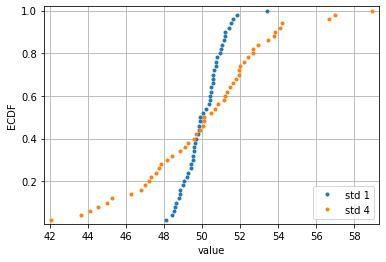

In [4]:
plot2ECDFs(samples_1, samples_2, leg=("std 1", "std 4"), xlab="value")

In [8]:
M = 1000 # no of samples
n = 500 # no of repetitions 

# Generate shifted arrays
samples_1_underNull = samples_1 - np.mean(samples_1) + mean_overall
samples_2_underNull = samples_2 - np.mean(samples_2) + mean_overall

for i in range(n):
    
    # Draw Bootstrap replicates 
    bs_reps_1 = draw_bs_reps(samples_1_underNull, np.mean, size=M)
    bs_reps_2 = draw_bs_reps(samples_2_underNull, np.mean, size=M)
    bs_diff_means = abs(bs_reps_1-bs_reps_2)

    # Draw Permutation replicates
    perm_diff_means = draw_perm_reps(samples_1_underNull, samples_2_underNull, diff_of_means, size=M)

    #Compute p-value, that absolute diff of means of bs samples is at least as extreme as what we observed
    p_bs = np.sum(bs_diff_means >= emp_diff_means)/len(bs_diff_means)
    test_decisions[i,0] = p_bs
    p_perm = np.sum(abs(perm_diff_means) >= emp_diff_means)/len(perm_diff_means)
    test_decisions[i,1] = p_perm

# Compute the type-I error rates for the two test procedures 
bs_t1_error_rate = np.sum(test_decisions[:,0]<=0.05)/ n
perm_t1_error_rate = np.sum(test_decisions[:,1]<=0.05)/ n

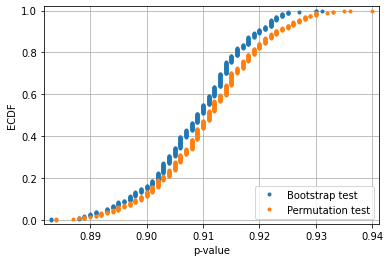

In [11]:
plot2ECDFs(test_decisions[:,0], test_decisions[:,1], leg=("Bootstrap test", "Permutation test"), xlab="p-value")

In [9]:
print("Type 1 error rate of bootstrap test:", bs_t1_error_rate)
print("Type 1 error rate of permutation test:", perm_t1_error_rate)

Type 1 error rate of bootstrap test: 0.0
Type 1 error rate of permutation test: 0.0


## 2. Random Walks
* Adjust the code from the lesson such that you are simulating a **biased** random walk that imitates Web clicks: With probability $p=0.1$ you take a positive step $x=1$ (yes click), and with $p=0.9$ you stay where you are $x=0$ (no click). "Launch" $1000$ walkers for $400$ time steps each.
* Write a function that (for each walker) tests the Null Hypothesis $H_0: p \leq 0.05$, $H_A: p > 0.05$ by applying this rule <br><br>
$$t = \frac{\sqrt{n} \cdot (\hat{p}- 0.05)}{\sqrt{0.05 \cdot 0.95}} > z_{1- \alpha} $$<br> where $\hat{p} = \sum x/n$ is the observed proportion of "ones" up to time step $n$.
* Compute the type-II error rates for time steps $50$, $100$ and $400$.
* Wouldn't it be nice to deploy an "early stopping" rule ? Try out the following strategy: stop the test **at any time** if your test statistic exceeds the threshold $z_{1- \alpha}$!
    * Compute your type-I error at the end of the $400$ time steps and compare to the one you set ($\alpha$).

In [78]:
prob_walk = 0.1
no_walkers = 1000
no_steps = 400
z1_min_a= 1.645 #value for Z1-alpha for alpha of 0.05 (taken from z-table)

In [64]:
# Create walks 
walks = np.empty((no_walkers, no_steps))
for i in range(no_walkers):
    walks[i,:] = [1 if x<=prob_walk else 0 for x in np.random.rand(400)]


In [121]:
def test_null_walks(walks, step, axis=1):
    t = (np.sqrt(step)*(np.mean(walks[:step], axis=axis)-0.05))/(np.sqrt(0.05*0.95))
    return t

In [127]:
#type-II error rates for time steps 50, 100 and 400
t2_err_50 = np.sum(test_null_walks(walks, 50)>z1_min_a)/walks.shape[0]  
t2_err_100 = np.sum(test_null_walks(walks, 100)>z1_min_a)/walks.shape[0]
t2_err_400 = np.sum(test_null_walks(walks, 400)>z1_min_a)/walks.shape[0]

In [128]:
print(t2_err_50)
print(t2_err_100)
print(t2_err_400)

0.026
0.079
0.394


In [145]:
#"early stopping" rule: the results list includes the number of steps it took to reject the null hypothesis for each walk 
results=[]
for i, steps in enumerate(walks):
    for j in range(1,no_steps+1):
        if test_null_walks(steps, j, axis=0) > z1_min_a:
            continue
        results.append(j)
        break

In [149]:
# type-I error at the end of the 400 time steps
t1_err_400 = np.sum(test_null_walks(walks, 400)>z1_min_a)/walks.shape[0]
t1_err_400

0.394